<a href="https://colab.research.google.com/github/josue2510/Data_science_2020_election_support/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vaderSentiment
!pip install nltk
!pip install gensim

     |████████████████████████████████| 125 kB 5.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')
from gensim.models import Word2Vec#libreria para representar palabras en vectores de números
import pandas as pd
from sklearn.cluster import KMeans
import math
from sklearn.metrics import silhouette_score, davies_bouldin_score#calcula el promedio de los coeficientes de silhouette de todas las muestras
from sklearn.metrics import silhouette_samples#calcula el coeficiente de silhouette de cada muestra
from sklearn.decomposition import PCA#reduce la dimensionalidad a n dimensiones
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter#subclase que cuenta objetos y almacena los elementos en un diccionario
import nltk#kit de herramientas de lenguaje natural
nltk.download('punkt')
from nltk import word_tokenize
from  tqdm import tqdm#libreria que mide el progreso de los loops
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
tweets = pd.read_csv("/content/drive/MyDrive/tweetsSentiment.csv", sep=',')
tweets.tweet = tweets.tweet.astype(str)

In [4]:
def get_tokens(text, tokenizer):
    """Tokeniza el texto recibido, remueve dígitos y tokens cortos

    Args:
        text: str

    Returns:
        tokens: array[str]
    """
    tokens = tokenizer(text)
    tokens = ["" if t.isdigit() else t for t in tokens]
    return tokens

In [5]:
#separamos cada tweet por palabra y los almacenamos en un vector
#para tener un vector de vectores, tokenizamos los tweets
tweets_words = tweets.tweet.apply(lambda x: get_tokens(x, word_tokenize))

In [6]:
#entrenamos el modelo Word2Vec usando los tweets tokenizados
model = Word2Vec(sentences=tweets_words, workers=1, seed=42)

In [7]:
def flatten(l):
    """ La funcion aplana una lista de listas 
        
        args:
            l (): lista de listas
        return : lista aplanada
    """
    return [item for sublist in l for item in sublist]

In [8]:
#Calculamos la frecuencia de cada palabra
flatten_tweets_words = flatten(tweets_words)
word_freq = nltk.FreqDist(flatten_tweets_words)

In [9]:
def tuple2array(value):
  """ La funcion convierte una tupla a un arrau
        
        args:
            value: tupla
        return : lista: array() 
    """
  lista = []
  for a_tuple in value:
    lista.append(a_tuple[0])
  return lista 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


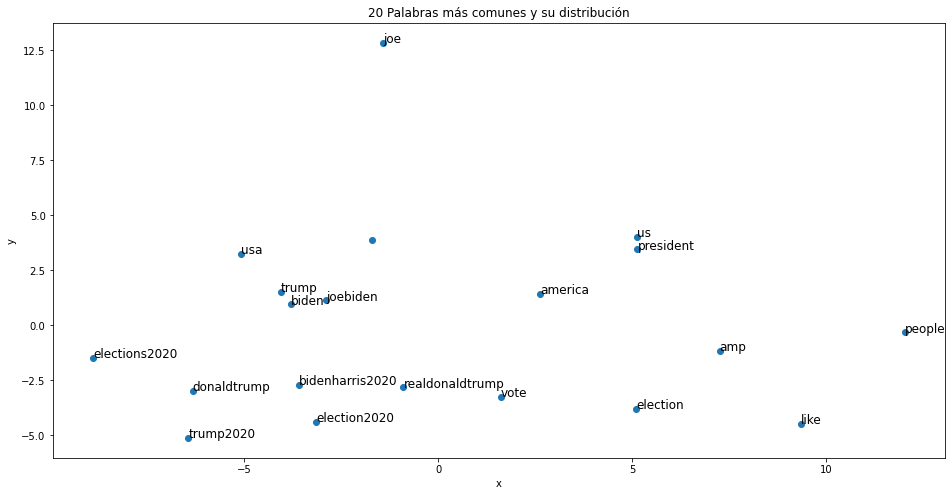

In [10]:
#Elegimos las 18 palabras más frecuentes y obtenemos sus vectores respectivos
common_words = tuple2array(word_freq.most_common(20))
X = model[common_words]
#Transformamos los vectores a 2 dimensiones usando PCA
pca = PCA(n_components=2)
result = pca.fit_transform(X)
#Creamos la representación de las 18 palabras más comunes en 2 dimensiones
plt.figure(figsize=(16,8))
plt.scatter(result[:, 0], result[:, 1])
words = list(common_words)
for i, word in enumerate(words):
  plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=12)
plt.title('20 Palabras más comunes y su distribución')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [11]:
#Función que crea un vector por tweet, promediando los vectores de las palabras que contiene
def vectorize(list_of_docs, model):
    """Genera vectores para la lista de documentos usando Word Embedding

    Args:
        list_of_docs: Lista de documentos
        model: modelo de Gensim Word2Vec entrenado

    Returns:
        features: Lista de documentos vectorizados
    """
    features = []
    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [12]:
vectorized_docs = vectorize(tweets_words, model=model)
len(vectorized_docs), len(vectorized_docs[0])

(2038732, 100)

100%|██████████| 11/11 [45:28<00:00, 248.08s/it]


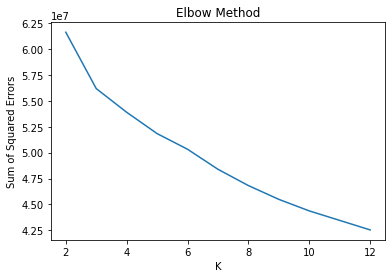

In [13]:
def plot_sse(features_X, start=2, end=13):
    sse = []
    for k in tqdm(range(start, end)):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.title("Elbow Method")
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
plot_sse(vectorized_docs)

In [14]:
#Agrupamos los diferentes tweets usando KMeans
scores=[]
for i in range(2,13):
  clustering = KMeans(n_clusters=i, random_state=10).fit(vectorized_docs)
  scores.append(davies_bouldin_score(vectorized_docs, clustering.labels_))
scores

[1.605645565107686,
 2.2079756248432436,
 2.017997906692716,
 2.31132432885203,
 1.914490382392381,
 2.1618194199977236,
 2.225273819778714,
 2.0892920004446465,
 2.120062968723869,
 2.1838666772126603,
 2.141149461131591]

In [15]:
clustering = KMeans(n_clusters=5).fit(vectorized_docs)
davies_bouldin_score(vectorized_docs, clustering.labels_)

2.274332944101001

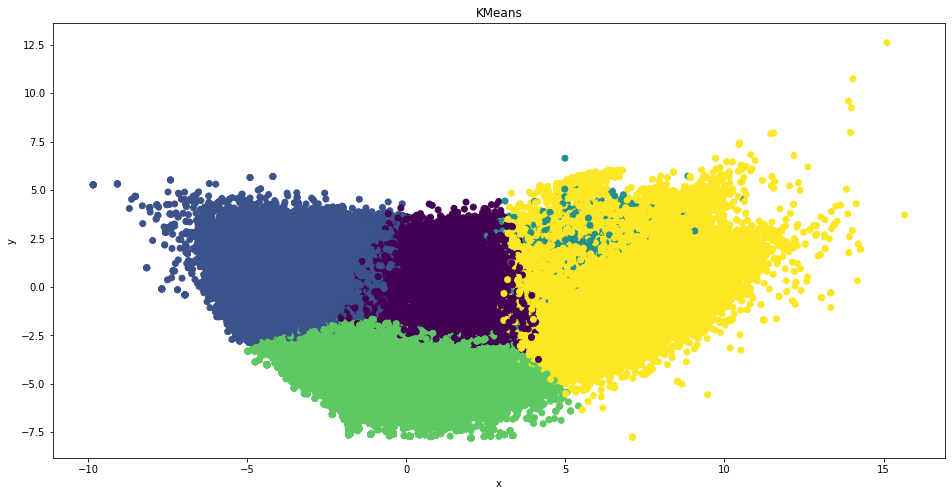

In [16]:
#Transformamos los vectores a 2 dimensiones usando PCA
pca = PCA(n_components=2)
result = pca.fit_transform(vectorized_docs)
#Creamos la representación de las 18 palabras más comunes en 2 dimensiones
plt.figure(figsize=(16,8))
plt.scatter(result[:, 0], result[:, 1], c=clustering.labels_)
plt.title('KMeans')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [17]:
tweets['cluster'] = clustering.labels_
cluster_count = Counter(tweets.cluster)
cluster_count

Counter({0: 472255, 1: 912691, 2: 60476, 3: 275160, 4: 318150})

In [18]:
#Obtenemos las palabras más representativas en cada cluster
print("Palabras más representativas por cluster(según la cercanía a su centroide):")
for i in range(5):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=10)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Palabras más representativas por cluster(según la cercanía a su centroide):
Cluster 0: today election2020 also trump realdonaldtrump amp actually really thats definitely 
Cluster 1: also actually amp really least still thats today especially way 
Cluster 2: auch skandale erlebt miese wahlflschungen verbindet explizit innenpolitische bislang demokratien 
Cluster 3: biden trump joebiden election2020 electionresults2020 bidenharris bidenharris2020 donaldtrump elections2020 uselection2020 
Cluster 4: moltissimo philippebarthe solidit chileunidoavanz patriotosorus significative revendication samuse encaisser tocard 


In [19]:
#Obtenemos los n tweets más representativos del cluster en específico
test_cluster = list(cluster_count.values()).index(max(cluster_count.values())) - 1
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
print("Tweets más representativos del cluster ",test_cluster)
for d in most_representative_docs[:5]:
    print(tweets['tweet'][d])
    print("-------------")

Tweets más representativos del cluster  1
hope joebiden always remembers trump never caused americas ugliness brought always visibly surface bidens mere election doesnt fix 70 mil still voted trump start bidenharris2020 joebiden
-------------
joe biden seems hv stolen march trump us electionsas say wheel time grinds slow grinds exceedingly small good know america move ahead liberal dispensation 13usaelection2020 joebiden uselectionresults2020
-------------
akala2 angrierwhstaff joyusaver calls emotional swings lots hang ups us reach caller truly worried doesnt like trump heard bs biden talking long takes get commit voting trump vote biden
-------------
love two living us vote biden honestly want trump win biden typical politician know sell well definitely default potustrump typical action taker rash decision making election btw amp
-------------
ww2 heroes electing amp worshiping man like donaldtrump guys almost pulled harvey dent therebut fact election close means theres still lot tox

In [20]:
def text_plot(y):
  for c, value in enumerate(y): 
    plt.text(c-0.08, value, str(value)) 

Text(0.5, 1.0, 'Análisis de sentimientos de los 50 tweets más virales del cluster 0')

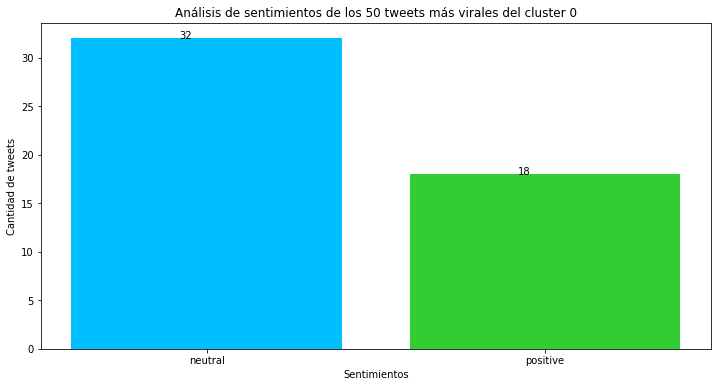

In [21]:
cluster0 = tweets[tweets.cluster == 0].sort_values(by='likes', ascending=False)[:50]
sentiment_cnt = Counter(cluster0.analysis)
plt.figure(figsize=(12,6))
plt.bar(sentiment_cnt.keys(), sentiment_cnt.values(), color=['deepskyblue', 'limegreen'])
plt.xlabel('Sentimientos')
plt.ylabel('Cantidad de tweets')
text_plot(sentiment_cnt.values())
plt.title("Análisis de sentimientos de los 50 tweets más virales del cluster 0")

Text(0.5, 1.0, 'Análisis de sentimientos de los 50 tweets más virales del cluster 0')

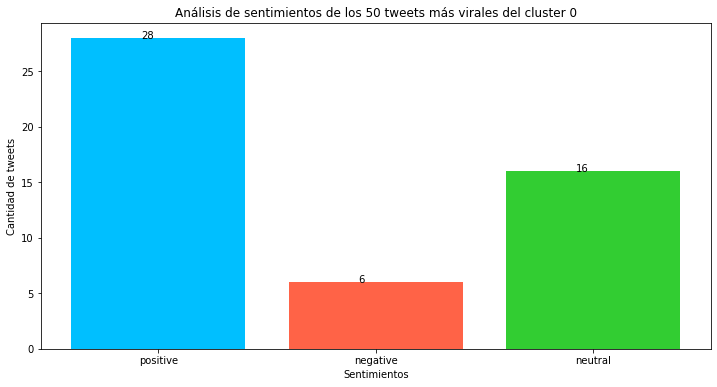

In [22]:
cluster1 = tweets[tweets.cluster == 1].sort_values(by='likes', ascending=False)[:50]
sentiment_cnt = Counter(cluster1.analysis)
plt.figure(figsize=(12,6))
plt.bar(sentiment_cnt.keys(), sentiment_cnt.values(), color=['deepskyblue', 'tomato','limegreen'])
plt.xlabel('Sentimientos')
plt.ylabel('Cantidad de tweets')
text_plot(sentiment_cnt.values())
plt.title("Análisis de sentimientos de los 50 tweets más virales del cluster 0")

Text(0.5, 1.0, 'Análisis de sentimientos de los 50 tweets más virales del cluster 0')

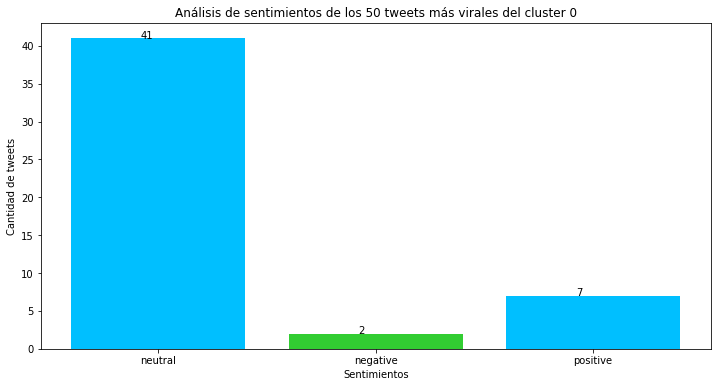

In [23]:
cluster2 = tweets[tweets.cluster == 2].sort_values(by='likes', ascending=False)[:50]
sentiment_cnt = Counter(cluster2.analysis)
plt.figure(figsize=(12,6))
plt.bar(sentiment_cnt.keys(), sentiment_cnt.values(), color=['deepskyblue', 'limegreen'])
plt.xlabel('Sentimientos')
plt.ylabel('Cantidad de tweets')
text_plot(sentiment_cnt.values())
plt.title("Análisis de sentimientos de los 50 tweets más virales del cluster 0")

Text(0.5, 1.0, 'Análisis de sentimientos de los 50 tweets más virales del cluster 0')

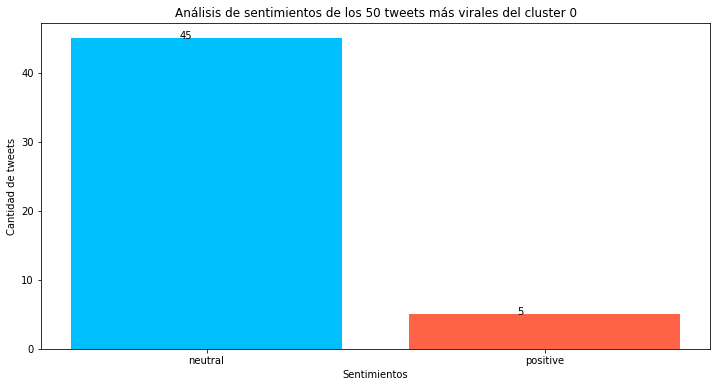

In [24]:
cluster3 = tweets[tweets.cluster == 3].sort_values(by='likes', ascending=False)[:50]
sentiment_cnt = Counter(cluster3.analysis)
plt.figure(figsize=(12,6))
plt.bar(sentiment_cnt.keys(), sentiment_cnt.values(), color=['deepskyblue', 'tomato','limegreen'])
plt.xlabel('Sentimientos')
plt.ylabel('Cantidad de tweets')
text_plot(sentiment_cnt.values())
plt.title("Análisis de sentimientos de los 50 tweets más virales del cluster 0")

Text(0.5, 1.0, 'Análisis de sentimientos de los 50 tweets más virales del cluster 0')

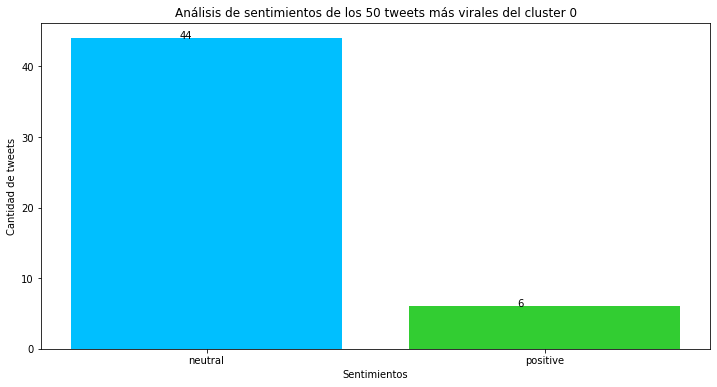

In [25]:
cluster4 = tweets[tweets.cluster == 4].sort_values(by='likes', ascending=False)[:50]
sentiment_cnt = Counter(cluster4.analysis)
plt.figure(figsize=(12,6))
plt.bar(sentiment_cnt.keys(), sentiment_cnt.values(), color=['deepskyblue', 'limegreen'])
plt.xlabel('Sentimientos')
plt.ylabel('Cantidad de tweets')
text_plot(sentiment_cnt.values())
plt.title("Análisis de sentimientos de los 50 tweets más virales del cluster 0")

In [26]:
for i in range(5):
  trump = tweets[tweets.cluster == i].trump.max()
  biden = tweets[tweets.cluster == i].biden.max()
  print(f"Cluster {i}: máximo número de menciones por candidato, Trump: {trump} - Biden: {biden}")

Cluster 0: máximo número de menciones por candidato, Trump: 32 - Biden: 22
Cluster 1: máximo número de menciones por candidato, Trump: 19 - Biden: 21
Cluster 2: máximo número de menciones por candidato, Trump: 11 - Biden: 7
Cluster 3: máximo número de menciones por candidato, Trump: 42 - Biden: 45
Cluster 4: máximo número de menciones por candidato, Trump: 37 - Biden: 20
